In [1]:
import netCDF4 as nc
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
import datetime
import pandas as pd 
import math
from scipy import interpolate

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

import warnings
warnings.filterwarnings("ignore")

/home/imachuca/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


# Model Stratification Date

In [2]:
profile_number = 21

ts_data_shal = sio.loadmat('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/data/for_stratification/canyonTSdata.mat')
ts_data_deep = sio.loadmat('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/data/for_stratification/canyonTSdata2.mat')

longitudes = np.concatenate((ts_data_shal['loncanyon'][0], ts_data_deep['loncanyon2'][0]),axis=0)
latitudes = np.concatenate((ts_data_shal['latcanyon'][0], ts_data_deep['latcanyon2'][0]),axis=0)
years = np.concatenate((ts_data_shal['yrcanyon'][0], ts_data_deep['yrcanyon2'][0]),axis=0)
days = np.concatenate((ts_data_shal['daycanyon'][0], ts_data_deep['daycanyon2'][0]),axis=0)
con_temps = np.concatenate((ts_data_shal['tempcanyon'], ts_data_deep['tempcanyon2']),axis=1)
abs_salts = np.concatenate((ts_data_shal['salcanyon'], ts_data_deep['salcanyon2']),axis=1)
depths = np.concatenate((ts_data_shal['depthcanyon'], ts_data_deep['depthcanyon2']),axis=1) * -1

dates = []
for i in range(len(days)):
    date = (datetime.datetime(years[i], 1, 1) + datetime.timedelta(days[i] - 1)).strftime('%b %d %Y')
    dates.append(date)

In [3]:
mod_lon = longitudes[profile_number]
mod_lat = latitudes[profile_number]

In [4]:
dates[profile_number]

'Aug 11 2009'

# Data Overview

In [5]:
df_casts = pd.read_excel('./LSSL_Geochemistry2009.xls', sheetname='Stn location summary')
df_casts.columns

Index(['Cast #', 'Station', 'CAST START TIME (UTC)', 'Lat Deg N', 'Lat Min',
       'N', 'latdec', 'Lon Deg', 'Lon Min', 'W', 'longdec', 'Long Dec  (neg)',
       'Water Depth (m)', 'Cast Depth (m)', 'Sample #'s',
       'Sound Speed (m/s) from Log Sheets'],
      dtype='object')

In [6]:
lat = np.array(df_casts['latdec'])
lon = np.array(df_casts['Long Dec  (neg)'])
time = np.array(df_casts['CAST START TIME (UTC)'])

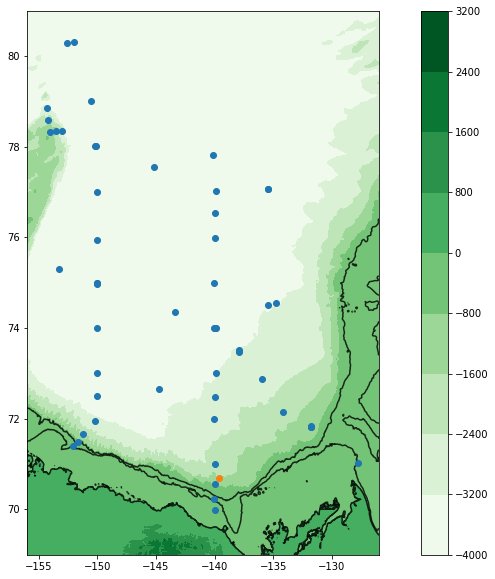

In [7]:
xn, yn, zn = functions_plot.def_regionG(-156, -126, 69.0, 81)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cf = ax.contourf(xn, yn, zn, cmap=cm.Greens)
ax.contour(xn, yn, zn, levels=[-400,-80,0], colors='k', linestyles='solid', alpha=0.8, zorder=1)
ax.scatter(lon, lat, zorder=2)
ax.scatter(mod_lon, mod_lat, zorder=3)
w=1/math.cos(math.radians(75))
ax.set_aspect(w)
fig.colorbar(cf, ax=ax)

In [8]:
time

array(['2009-09-19T23:56:06.000000000', '2009-09-20T12:38:30.000000000',
       '2009-09-20T19:07:47.000000000', '2009-09-21T01:30:42.000000000',
       '2009-09-22T17:10:52.000000000', '2009-09-23T01:14:55.000000000',
       '2009-09-23T10:09:45.000000000', '2009-09-23T17:00:19.000000000',
       '2009-09-24T08:41:16.000000000', '2009-09-24T22:50:38.000000000',
       '2009-09-27T02:58:07.000000000', '2009-09-27T04:36:09.000000000',
       '2009-09-27T07:12:26.000000000', '2009-09-27T10:19:47.000000000',
       '2009-09-28T04:52:58.000000000', '2009-09-28T08:19:03.000000000',
       '2009-09-28T10:52:27.000000000', '2009-09-28T15:32:45.000000000',
       '2009-09-28T21:05:12.000000000', '2009-09-29T01:21:14.000000000',
       '2009-09-29T09:58:17.000000000', '2009-09-29T16:30:42.000000000',
       '2009-09-29T21:17:27.000000000', '2009-09-30T06:06:12.000000000',
       '2009-09-30T13:47:45.000000000', '2009-10-01T02:43:10.000000000',
       '2009-10-01T10:05:07.000000000', '2009-10-01

# Geochemistry Data

In [9]:
df_description = pd.read_excel('./LSSL_Geochemistry2009.xls', sheetname='ChemMetadata')
df_description.iloc[[20,22,23,24,25]]

,ChemMetadata,Unnamed: 1,Unnamed: 2,Unnamed: 3
20,Salt [PSS-78],Salinity [PSS-78],[PSS-78],NaN
22,Oxy [mmol/m3],Oxygen [mmol/m3],[mmol/m3],NaN
23,NO3 [mmol/m3],Nitrate + Nitrite [mmol/m3],[mmol/m3],NaN
24,SiO4 [mmol/m3],Reactive Silicate [mmol/m3],[mmol/m3],NaN
25,PO4 [mmol/m3],Orthophosphate [mmol/m3],[mmol/m3],NaN


In [10]:
df_data = pd.read_excel('./LSSL_Geochemistry2009.xls', sheetname='2009-20_LSSL_Chem')
df_data.columns

Index(['Cruise', 'Cast No. ', 'Station Name', 'Cast Start Time [UTC]',
       'LAT DEG', 'LAT MIN', 'N', 'LAT N', 'LON DEG', 'LON MIN', 'W', 'LON W',
       'LON E', 'Sample No. [All others match to this sample number]',
       'Bottle Integrity (if bottle didn't close where expected, all sample have QF adjusted)',
       'Trip [US (up stop), UN (up no stop), USM (up stop mix) or DN (down no stop)]',
       'Rosette Bot No.', 'CTDPres\n[dbar] ', 'CTDTemp-1\n [ITS-90 C] ',
       'CTDTemp-2\n[ITS-90 C] ', 'CTDCond-1\n[mS/cm] ', 'CTDCond-2\n[mS/cm] ',
       'CTDSalt-1\n[PSS-78] ', 'CTDSalt-2\n[PSS-78] ',
       'CTDOxy\n[volts]\ndowncast', 'CTDOxy\n[mL/L]\ndowncast',
       'CTDOxy\n[% Sat]\ndowncast', 'CTDFluo\n[mg/m3]', 'CTDFluo\n[volts] raw',
       'CTDTrans\n[%]', 'CTDCDOM\n[volts] raw', 'CTDNO3ISUS\n[volts] raw',
       'CTDAlt\n[m]', 'CTDSPAR\n[uE/m2/sec]', 'Salt\n[PSS-78]      ', 'IOS QF',
       'Oxy\n[mL/L]', 'Oxy\n[mmol/m3]', 'IOS QF.1',
       'Was Nutrient Sample Frozen? (I

In [11]:
Oxy = np.array(df_data['Oxy\n[mmol/m3]'])
NO3 = np.array(df_data['NO3\n[mmol/m3]'])
SiO4 = np.array(df_data['SiO4\n[mmol/m3]'])
PO4 = np.array(df_data['PO4\n[mmol/m3]'])
salt = np.array(df_data['Salt\n[PSS-78]      '])

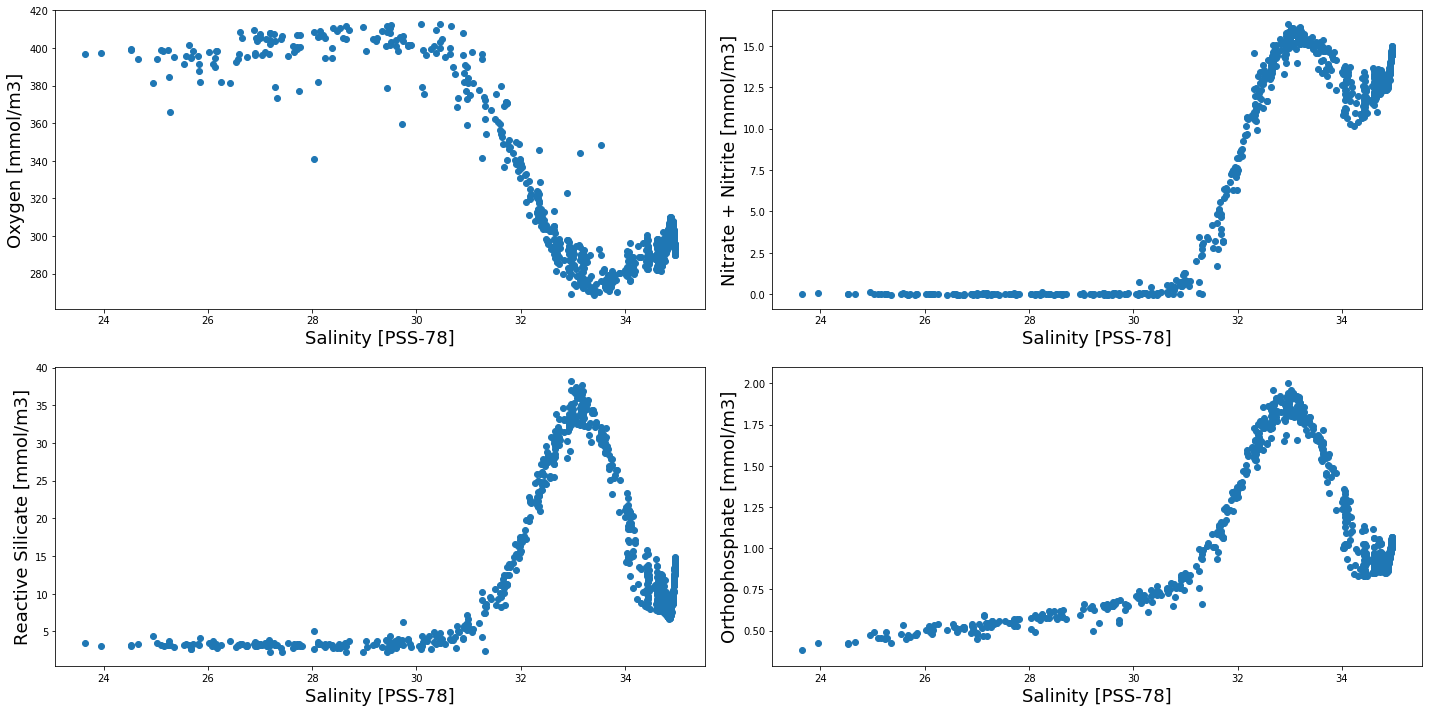

In [12]:
nutrients = [Oxy, NO3, SiO4, PO4]
nutrient_names = ['Oxygen [mmol/m3]', 'Nitrate + Nitrite [mmol/m3]', 'Reactive Silicate [mmol/m3]', 'Orthophosphate [mmol/m3]']

fig, axes = plt.subplots(2,2,figsize=(20, 10))
for ax, nutrient, nutrient_name in zip(axes.flatten(), nutrients, nutrient_names):
    ax.scatter(salt, nutrient)
    ax.set_ylabel(nutrient_name, fontsize=18)
    ax.set_xlabel('Salinity [PSS-78]', fontsize=18)
fig.tight_layout(w_pad=1.2, h_pad=1.5)

# Interpolation Function

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html

In [15]:
idx_finite = np.isfinite(PO4)
f_interp = interpolate.interp1d(salt[idx_finite], PO4[idx_finite], fill_value='extrapolate')

salt_new = np.arange(np.nanmin(salt), np.nanmax(salt), 0.01)
PO4_new = f_interp(salt_new)

PO4_smooth = np.copy(PO4_new)
ind1, ind2, ind3, ind4 = 250, 800, 900, 1000
#box1, box2, box3, box4, box5 = 10, 30, 5, 15, 15
#PO4_smooth[:ind1] = pd.rolling_mean(PO4_new[:ind1], box1)
#PO4_smooth[ind1:ind2] = pd.rolling_mean(PO4_new[ind1:ind2], box2)
#PO4_smooth[ind2:ind3] = pd.rolling_mean(PO4_new[ind2:ind3], box3)
#PO4_smooth[ind3:ind4] = pd.rolling_mean(PO4_new[ind3:ind4], box4)
#PO4_smooth[ind4:] = pd.rolling_mean(PO4_new[ind4:], box5)
PO4_smooth[:] = pd.rolling_mean(PO4_new[:], 15)

salt.shape, salt_new.shape, PO4_new.shape

((1146,), (1133,), (1133,))

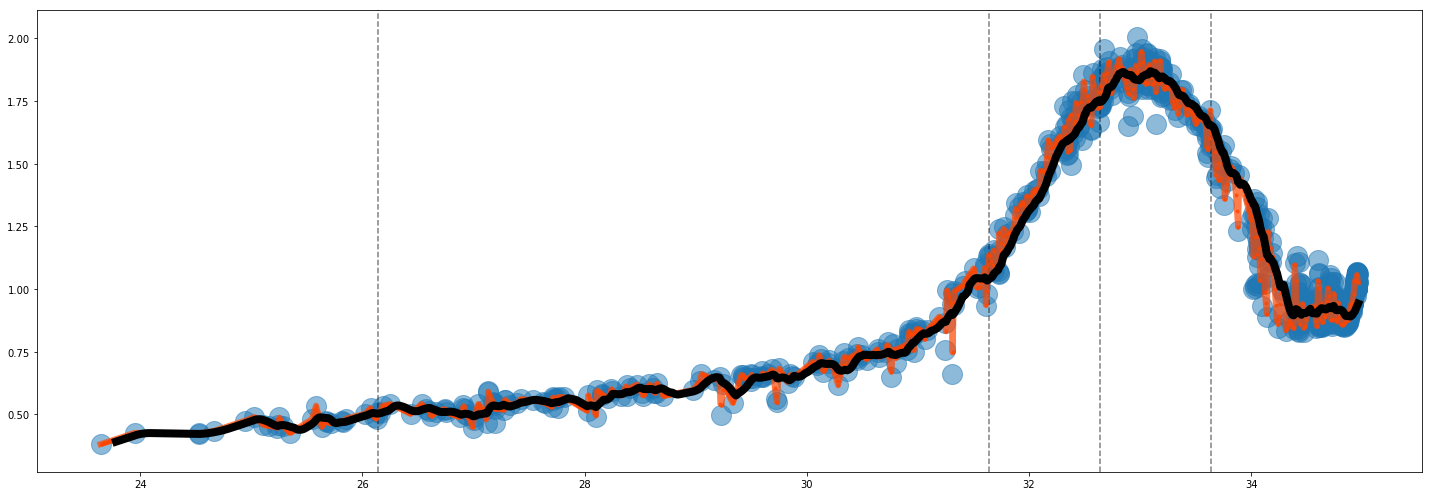

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

ax.scatter(salt, PO4, s=400, alpha=0.5)

ax.plot(salt_new, PO4_new, lw=6, c='orangered', marker='.', alpha=0.7)

ax.plot(salt_new, PO4_smooth, lw=8, c='k', marker='.')

for indx in [ind1, ind2, ind3, ind4]:
    ax.axvline(salt_new[indx], c='k', alpha=0.5, linestyle='--', zorder=1)

fig.tight_layout(w_pad=1.2, h_pad=1.5)

# Trying on one file

In [17]:
fileT = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/1_MCKNZ_1h_20170101_20170110_grid_T_20170103-20170103.nc')
fileM = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/1_mesh_mask.nc')

In [18]:
vosaline0 = fileT['vosaline'][0, 9, :, :]
tmask = fileM['tmask'][0, 9, :, :]
vosaline = np.ma.array(vosaline0, mask=1 - tmask)

print(np.nanmin(vosaline0), np.nanmax(vosaline0))
print(np.nanmin(vosaline), np.nanmax(vosaline))
print(vosaline.shape, tmask.shape)

0.0 34.404457
31.33988 34.404457
(244, 274) (244, 274)


In [19]:
salt_mod = vosaline0
PO4_mod = np.full_like(salt_mod, np.nan)

f_interp_final = interpolate.interp1d(salt_new, PO4_smooth, fill_value='extrapolate')

for j in range(salt_mod.shape[-2]):
    for i in range(salt_mod.shape[-1]):
         PO4_mod[j,i] = f_interp_final(salt_mod[j,i])
        
np.nanmin(PO4_mod), np.nanmax(PO4_mod)

(0.8952487, 1.8693273)

Text(0.5,1,'PO4')

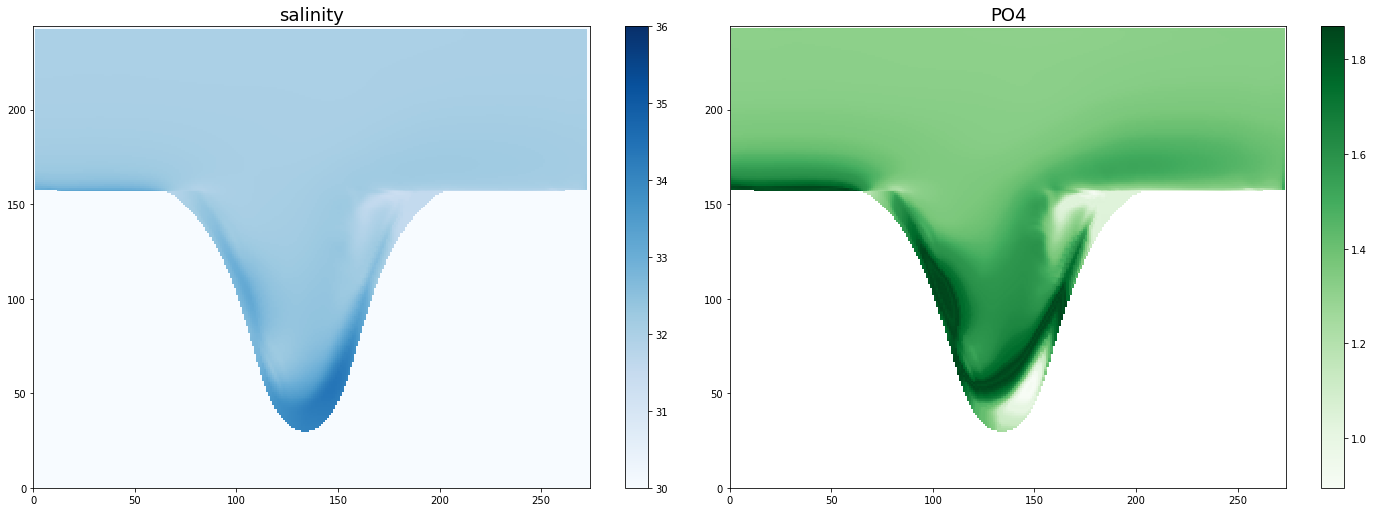

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
p1 = ax1.pcolormesh(salt_mod, cmap=cm.Blues, vmin=30, vmax=36)
p2 = ax2.pcolormesh(PO4_mod, cmap=cm.Greens)
fig.colorbar(p1, ax=ax1)
fig.colorbar(p2, ax=ax2)
fig.tight_layout(w_pad=1.2, h_pad=1.5)
ax1.set_title('salinity', fontsize=18)
ax2.set_title('PO4', fontsize=18)